This notebook shows the plotting process for Figure 4 in the main text.<br>
First, in the [processing data](#processing-data) section, we calculate average performance and exploration metrics for scientists before and after each split point, and group scientists according to the EP&ED metrics. We then use the code **5_1_PSW.R** to obtain the ATE between groups under different split points.<br>
In the [draw subgraph(a)](#draw-subgraph(a)) section, we calculate the average future performance of the four high/low EP/ED groups under different split points and plot the **Figure 4(a)** in the main text.<br>
In the [draw subgraph(b)](#draw-subgraph(b)) section, we choose the high-EP-high-ED group as the baseline, calculate the inter-group ATE and plot the **Figure 4(b)**.<br>
In the [draw subgraph(c)](#draw-subgraph(c)) section, we compute the ATE of the high-EP-low-ED group compared to the low-EP-high-ED group and all other groups as the baseline, and then draw **Figure 4(c)**.<br>
In the [draw subgraph(d)](#draw-subgraph(d)) section, we try different thresholds on EPs and EDs to get four groups, calculate the inter-group ATE, and then plot **Figure 4(d)**.<br>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from itertools import *

# processing data
This section is used to obtain the covariates and grouping results when different career years serve as split points.

In [2]:
def get_level1(genres):
    listlevel = []
    for i in genres:
        thislist = []
        for k in i:
            thislist.append(k[:2])
        thislist = list((thislist))
        listlevel.append(thislist)
    return listlevel

In [3]:
DATA_path = '../data/processing_data/'
author_paper = pd.read_pickle(DATA_path+"author_paper.pkl")
author_paper = author_paper[author_paper.paperCount >= 10]
author_paper = author_paper.sort_values(['aid', 'date'])

distance_info = pd.read_pickle(DATA_path+"avg_switch_distance_info.pkl")
distance_info = distance_info[distance_info.aid.isin(author_paper.aid)]
distance_info = distance_info[['aid', 'lastDate',
                               'thisDate', 'N5_es_distance', 'N5_es']]
distance_info = distance_info.sort_values(['aid', 'lastDate'])
distance_info = distance_info.reset_index(drop=True)

author_paper['two_code_genres'] = get_level1(list(author_paper.genres))
author_paper_before2 = author_paper.groupby(['aid']).head(1)
author_paper_before2 = author_paper_before2[['aid', 'two_code_genres']]

In [4]:
def get_dummy(datak):
    list100 = []
    aidlist = []

    num_genres = list(set(list(chain(*list(datak.genre_level0)))))
    num_genres.sort()
    num_genres = dict(zip(num_genres, range(0, len(num_genres))))

    for i, g in datak.groupby(['aid']):
        aidlist.append(i)
        this_genres = [np.nan]*len(num_genres)
        i = list(g.genre_level0)[0]

        for t_i in i:
            this_genres[int(num_genres[t_i])] = 1
        list100.append(this_genres)

    aid_genre = pd.DataFrame(list100)
    aid_genre.columns = ['Genre_'+str(i) for i in aid_genre.columns]
    aid_genre.fillna(0, inplace=True)

    aid_genre['aid'] = aidlist
    datak = datak.merge(aid_genre, on=['aid'])
    return datak

In [5]:
author_paper['date'] = pd.to_datetime(author_paper['date'])
author_paper['firstyear'] = author_paper.aid.map(
    author_paper.groupby(['aid']).date.min().to_dict())
author_paper["CareerYear"] = (
    author_paper["date"]-author_paper["firstyear"]).dt.days//365 + 1

distance_info['lastDate'] = pd.to_datetime(distance_info['lastDate'])
distance_info['thisDate'] = pd.to_datetime(distance_info['thisDate'])
distance_info['firstyear'] = distance_info.aid.map(
    distance_info.groupby(['aid']).lastDate.min().to_dict())

In [6]:
def career(careeryear):
    '''
    Description: Obtain the average performance and exploration metrics of scientists before and after the split point.
    Input: careeryear: set the split point.
    Output: Average performance and exploration metrics of scientists before and after the split point.
    '''

    # performance
    author_paper_after = author_paper[author_paper.CareerYear > careeryear].groupby(
        ['aid']).agg({'logCit': 'mean', 'paperDoi': 'count', 'citCount': 'mean'}).reset_index()
    author_paper_before = author_paper[author_paper.CareerYear <= careeryear]
    author_paper_before = author_paper_before[author_paper_before.aid.isin(
        author_paper_after.aid)]
    author_paper_before1 = author_paper_before.groupby(['aid']).agg(
        {'logCit': 'mean', 'paperDoi': 'count', 'firstyear': 'min'}).reset_index()
    author_paper_before1.firstyear = author_paper_before1.firstyear.dt.year

    # exploratory metrics
    distance_info_re["CareerYear"] = (
        distance_info_re["thisDate"]-distance_info_re["firstyear"]).dt.days//365 + 1
    distance_info_before = distance_info_re[distance_info_re.CareerYear <= careeryear]
    distance_info_before = distance_info_before[distance_info_before.aid.isin(
        author_paper_after.aid)]
    distance_info_before = distance_info_before.groupby(['aid']).agg(
        {'N5_es': 'mean', 'N5_es_distance': 'mean'}).reset_index()

    # regression
    regression = author_paper_before1.merge(author_paper_before2, on=['aid'])
    regression = regression.merge(distance_info_before, on=['aid'])
    regression = regression.merge(author_paper_after, on=['aid'])
    regression = regression.rename(columns={'paperDoi_x': 'paperDoi'})
    regression = regression[regression.paperDoi >= 5]
    regression = regression[regression.paperDoi_y >= 3]
    regression = regression.loc[:, (regression != 0).any(axis=0)]
    regression.rename(columns={'N5_es_distance': 'switch', 'logCit_x': 'pre_citCount', 'firstyear': 'firstyear', 'two_code_genres': 'genre_level0',
                               'first_genre': 'genre_level0', 'N5_es': 'es', 'paperDoi': 'Ncount', 'logCit_y': 'logCit', 'paperDoi_y': 'post_paperCount'}, inplace=True)
    regression['firstyear'] = regression['firstyear'].astype(
        'str').str.replace('', 'a', 1)
    regression = get_dummy(regression)

    return regression

In [7]:
# group scientists into 4 groups according to the EP&ED metrics
result = pd.DataFrame({})
for careeryear in range(2, 16):
    distance_info_re = distance_info.rename(columns={'N5_es': 'N5_es'})
    paper = career(careeryear)

    switchcut1 = list(paper['switch'].quantile(
        [.05, .1, .15, .2,  .25, .3, .4, .5, .6, .7, .75, .8, .85, .9, .95]))
    switchcut2 = list(paper['es'].quantile(
        [.05, .1, .15, .2,  .25, .3, .4, .5, .6, .7, .75, .8, .85, .9, .95]))

    print(careeryear)
    print(switchcut2[6:9])

    count_i = 7
    # Here high-EP-low-ED scientists go to group A, low-EP-low-ED ones B,
    # high-EP-high-ED ones C and the rest (low-EP-high-ED ones) D.
    for label in ['quantile_50']:
        if (count_i == 7):
            paper.loc[(paper.switch < switchcut1[count_i]) & (
                paper.es > switchcut2[count_i]), label] = 'A'
            paper.loc[(paper.switch < switchcut1[count_i]) & (
                paper.es < switchcut2[count_i]), label] = 'B'
            paper.loc[(paper.switch > switchcut1[count_i]) & (
                paper.es > switchcut2[count_i]), label] = 'C'
            paper.loc[(paper.switch > switchcut1[count_i]) & (
                paper.es < switchcut2[count_i]), label] = 'D'

    paper['careeryear_split_point'] = careeryear
    result = result.append(
        paper[['careeryear_split_point', 'aid', 'citCount', 'quantile_50']])
result.to_csv('../data/fig4/raw_split_data.csv', index=False)

2
[0.25, 0.3333333333333333, 0.4]
3
[0.25, 0.3333333333333333, 0.4]
4
[0.2857142857142857, 0.375, 0.42857142857142855]
5
[0.3, 0.375, 0.42857142857142855]
6
[0.3333333333333333, 0.375, 0.42857142857142855]
7
[0.3333333333333333, 0.375, 0.42857142857142855]
8
[0.3333333333333333, 0.375, 0.42857142857142855]
9
[0.3333333333333333, 0.375, 0.42857142857142855]
10
[0.3333333333333333, 0.375, 0.42857142857142855]
11
[0.3333333333333333, 0.375, 0.42857142857142855]
12
[0.3333333333333333, 0.375, 0.42857142857142855]
13
[0.3333333333333333, 0.375, 0.4230769230769231]
14
[0.3333333333333333, 0.375, 0.42105263157894735]
15
[0.3333333333333333, 0.375, 0.4230769230769231]


# draw subgraph(a)
First, we calculate the future mean citations for the high/low EP/ED groups under different split points. Then, we can plot Figure 4(a).

In [8]:
result = pd.read_csv('../data/fig4/raw_split_data.csv')
result = result.groupby(
    ['careeryear_split_point', 'quantile_50']).citCount.mean().reset_index()
result.sort_values(['careeryear_split_point', 'quantile_50'], inplace=True)

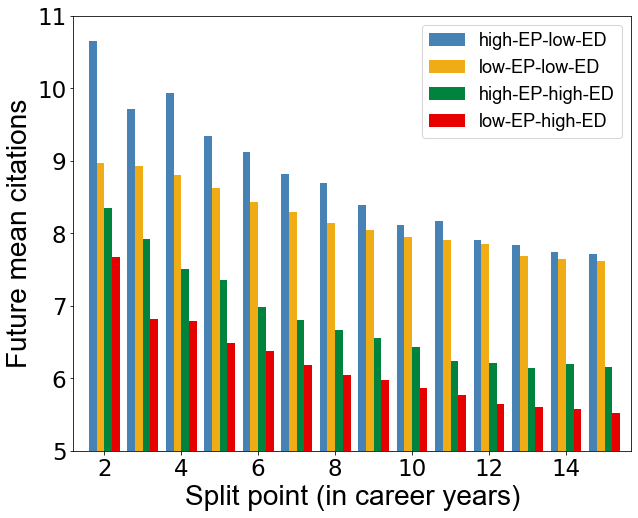

In [9]:
fontsize = 28
font_conf = {'family': 'Arial', 'weight': 'normal', 'size': fontsize}

plt.figure(figsize=(10, 8))
x = np.array(range(2, 16))
width = .2
plt.bar(x - 3*width/2, result[result.quantile_50 == 'A'].citCount,
        width, label='high-EP-low-ED', color='steelblue')
plt.bar(x - width/2, result[result.quantile_50 == 'B'].citCount, width, label='low-EP-low-ED',
        color=(0.9411764705882353, 0.6745098039215687, 0.08235294117647059, 1.0))
plt.bar(x + width/2, result[result.quantile_50 == 'C'].citCount, width,
        label='high-EP-high-ED', color=(0.0, 0.5137254901960784, 0.23921568627450981, 1.0))
plt.bar(x + 3*width/2, result[result.quantile_50 == 'D'].citCount, width,
        label='low-EP-high-ED', color=(0.9019607843137255, 0.0, 0.0, 1.0))

plt.ylabel('Future mean citations', fontdict=font_conf)
plt.xlabel('Split point (in career years)', fontdict=font_conf)
plt.yticks(fontsize=fontsize-5)
plt.xticks(fontsize=fontsize-5)
plt.ylim(5, 11)
plt.xlim(1.2, 15.7)
plt.legend(prop={'family': 'Arial', 'weight': 'normal',
           'size': fontsize-10}, loc='best')

plt.savefig('./draw/figure_4a.png', format="png", bbox_inches="tight")

# draw subgraph(b)
First, we use 5_1_PSW.R to obtain the ATE between the 4 groups at different split points when high-EP-high-ED group is set as the baseline. Then, we can plot Figure 4(b).

In [10]:
result = pd.read_csv('../data/fig4/ATE_result_baselineC.csv')

In [11]:
# 获取不同组的ATE
D_C = list(result['D-C'])
B_C = list(result['B-C'])
A_C = list(result['A-C'])
D_C_co, B_C_co, A_C_co = [], [], []
D_C_left, B_C_left, A_C_left = [], [], []
D_C_right, B_C_right, A_C_right = [], [], []
for stri in ['D_C', 'B_C', 'A_C']:
    for i in eval(stri):
        if (i.find('~') >= 0):
            i = i.split('~')
            eval(stri+'_left').append(float(i[0]))
            eval(stri+'_right').append(float(i[1]))
        else:
            eval(stri+'_co').append(float(i))

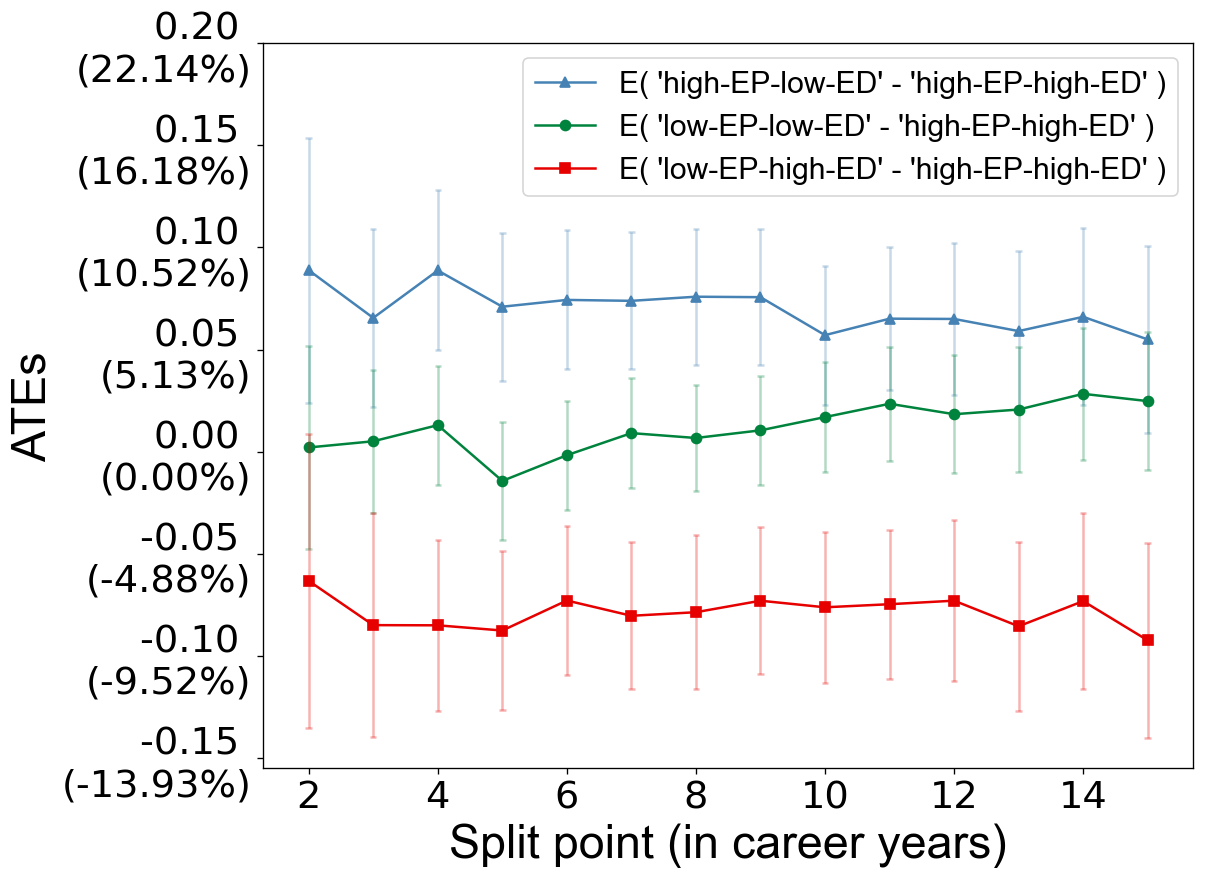

In [12]:
x_label = list(range(2, 16))

font_conf = {'family': 'Arial', 'weight': 'normal', 'size': fontsize}

fig = plt.figure(figsize=(10, 8), dpi=120)  # 12，6  10,8

index = 2
y = A_C_co
plt.plot(x_label, y, label="E( 'high-EP-low-ED' - 'high-EP-high-ED' )",
         marker='^', color='steelblue')
y1 = A_C_left
y2 = A_C_right
for x_i in range(len(x_label)):
    plt.vlines(x_label[x_i], y1[x_i], y2[x_i], color="steelblue", alpha=.3)
    plt.hlines(y1[x_i], x_label[x_i]-0.05, x_label[x_i] +
               0.05, color="steelblue", alpha=.3)
    plt.hlines(y2[x_i], x_label[x_i]-0.05, x_label[x_i] +
               0.05, color="steelblue", alpha=.3)

color = (0.0, 0.5137254901960784, 0.23921568627450981, 1.0)
index = 1
y = B_C_co
plt.plot(x_label, y, label="E( 'low-EP-low-ED' - 'high-EP-high-ED' )",
         marker='o', color=color)
y1 = B_C_left
y2 = B_C_right
for x_i in range(len(x_label)):
    plt.vlines(x_label[x_i], y1[x_i], y2[x_i], color=color, alpha=.3)
    plt.hlines(y1[x_i], x_label[x_i]-0.05,
               x_label[x_i]+0.05, color=color, alpha=.3)
    plt.hlines(y2[x_i], x_label[x_i]-0.05,
               x_label[x_i]+0.05, color=color, alpha=.3)

color = (0.9019607843137255, 0.0, 0.0, 1.0)
index = 0
y = D_C_co
plt.plot(x_label, y, label="E( 'low-EP-high-ED' - 'high-EP-high-ED' )",
         marker='s', color=color)
y1 = D_C_left
y2 = D_C_right
for x_i in range(len(x_label)):
    plt.vlines(x_label[x_i], y1[x_i], y2[x_i], color=color, alpha=.3)
    plt.hlines(y1[x_i], x_label[x_i]-0.05,
               x_label[x_i]+0.05, color=color, alpha=.3)
    plt.hlines(y2[x_i], x_label[x_i]-0.05,
               x_label[x_i]+0.05, color=color, alpha=.3)


foo = list(plt.yticks()[0])[1:]
foonew = []
for kk in (foo):
    tt = ('%.2f%%' % ((math.exp(kk)-1)*100))
    foonew.append('%.2f \n(%s)' % (kk, tt))

plt.xticks(fontsize=fontsize-5)
plt.yticks(ticks=foo, labels=foonew, fontsize=fontsize-5)


plt.ylabel('ATEs', fontdict=font_conf)
plt.xlabel('Split point (in career years)', fontdict=font_conf)
plt.legend(prop={'family': 'Arial', 'weight': 'normal',
           'size': fontsize-10}, loc=1)
plt.savefig('./draw/figure_4b.png', bbox_inches='tight')

# draw subgraph(c)
First, we use 5_1_PSW.R to obtain the ATE between the 4 groups at different split points. Then, we can plot Figure 4(c).

In [13]:
result = pd.read_csv('../data/fig4/ATE_result_baselineD.csv')
result2 = pd.read_csv('../data/fig4/ATE_A_others.csv')
result3 = pd.read_csv('../data/fig4/null.csv')

In [14]:
A_D = list(result['A-D'])
A_D_co = []
A_D_left = []
A_D_right = []
for stri in ['A_D']:
    for i in eval(stri):
        if (i.find('~') >= 0):
            i = i.split('~')
            eval(stri+'_left').append(float(i[0]))
            eval(stri+'_right').append(float(i[1]))
        else:
            eval(stri+'_co').append(float(i))

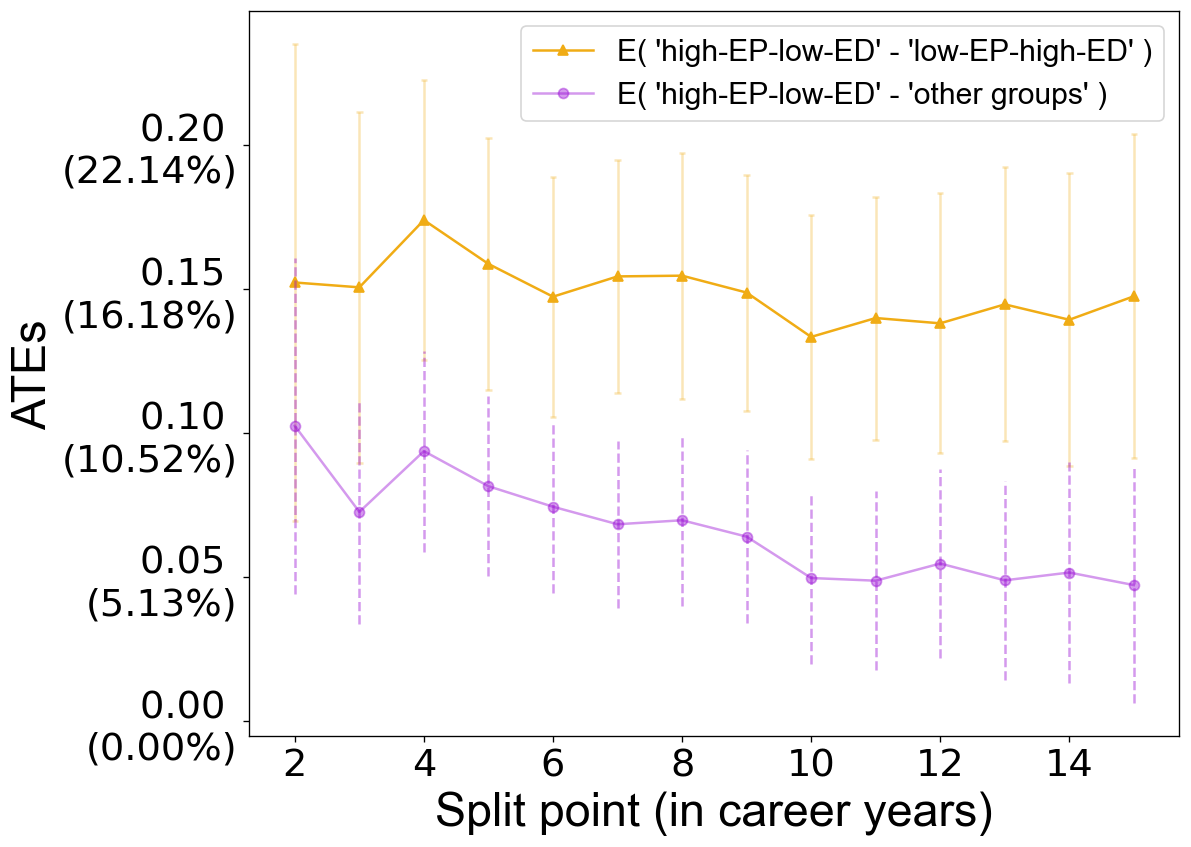

In [15]:
x_label = list(range(2, 16))

font_conf = {'family': 'Arial', 'weight': 'normal', 'size': fontsize}

fig = plt.figure(figsize=(10, 8), dpi=120)  # 12，6  10,8

index = 2
color = (0.9411764705882353, 0.6745098039215687, 0.08235294117647059, 1.0)
y = A_D_co
plt.plot(x_label, y,  marker='^', color=color,
         label="E( \'high-EP-low-ED\' - \'low-EP-high-ED\' )")
y1 = A_D_left
y2 = A_D_right
for x_i in range(len(x_label)):
    plt.vlines(x_label[x_i], y1[x_i], y2[x_i], color=color, alpha=.3)
    plt.hlines(y1[x_i], x_label[x_i]-0.05,
               x_label[x_i]+0.05, color=color, alpha=.3)
    plt.hlines(y2[x_i], x_label[x_i]-0.05,
               x_label[x_i]+0.05, color=color, alpha=.3)

color = 'darkviolet'  # (0.6, 0.4, 1.0, 1)
plt.plot(range(2, 16), result2['coe'], 'o-', color=color,
         alpha=.4, label="E( 'high-EP-low-ED' - 'other groups' ) ")
y1 = result2['l']
y2 = result2['r']
for x_i in range(len(x_label)):
    plt.vlines(x_label[x_i], y1[x_i], y2[x_i],
               linestyles="dashed", color=color, alpha=.4)

foo = list(plt.yticks()[0])[1:-1]
foonew = []
for kk in (foo):
    tt = ('%.2f%%' % ((math.exp(kk)-1)*100))
    foonew.append('%.2f \n(%s)' % (kk, tt))

plt.xticks(fontsize=fontsize-5)
plt.yticks(ticks=foo, labels=foonew, fontsize=fontsize-5)

plt.ylabel('ATEs', fontdict=font_conf)
plt.xlabel('Split point (in career years)', fontdict=font_conf)
plt.legend(prop={'family': 'Arial', 'weight': 'normal',
           'size': fontsize-10}, loc=1)
plt.savefig('./draw/figure_4c.png', bbox_inches='tight')

# draw subgraph(d)
First, we use 5_1_PSW.R to obtain the inter-group ATE when setting different thresholds to form four groups. Then, we can plot Figure 4(d).

In [16]:
result = pd.read_csv('../data/fig4/ATE_result_quantiles.csv')

In [17]:
D_C = list(result['D-C'])
B_C = list(result['B-C'])
A_C = list(result['A-C'])
D_C_co, B_C_co, A_C_co = [], [], []
D_C_left, B_C_left, A_C_left = [], [], []
D_C_right, B_C_right, A_C_right = [], [], []
for stri in ['D_C', 'B_C', 'A_C']:
    for i in eval(stri):
        if (i.find('~') >= 0):
            i = i.split('~')
            eval(stri+'_left').append(float(i[0]))
            eval(stri+'_right').append(float(i[1]))
        else:
            eval(stri+'_co').append(float(i))

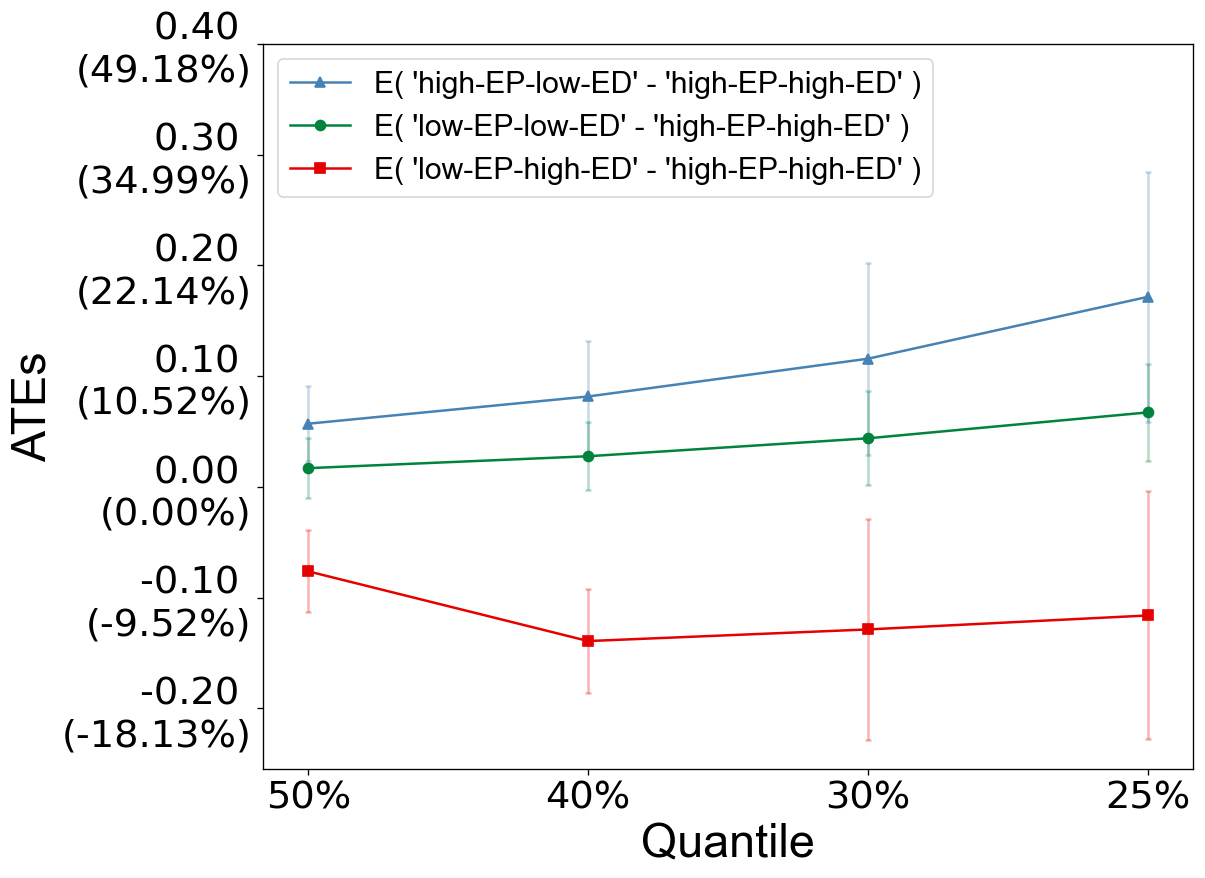

In [18]:
x_label_name = ['50%', '40%', '30%', '25%']
x_label = list(range(len(x_label_name)))


font_conf = {'family': 'Arial', 'weight': 'normal', 'size': fontsize}

fig = plt.figure(figsize=(10, 8), dpi=120)

index = 2
y = A_C_co
plt.plot(x_label_name, y, label="E( 'high-EP-low-ED' - 'high-EP-high-ED' )",
         marker='^', color='steelblue')
y1 = A_C_left
y2 = A_C_right
for x_i in range(len(x_label)):
    plt.vlines(x_label[x_i], y1[x_i], y2[x_i], color="steelblue", alpha=.3)
    plt.hlines(y1[x_i], x_label[x_i]-0.01, x_label[x_i] +
               0.01, color="steelblue", alpha=.3)
    plt.hlines(y2[x_i], x_label[x_i]-0.01, x_label[x_i] +
               0.01, color="steelblue", alpha=.3)

color = (0.0, 0.5137254901960784, 0.23921568627450981, 1.0)
index = 1
y = B_C_co
plt.plot(x_label_name, y, label="E( 'low-EP-low-ED' - 'high-EP-high-ED' )",
         marker='o', color=color)
y1 = B_C_left
y2 = B_C_right
for x_i in range(len(x_label)):
    plt.vlines(x_label[x_i], y1[x_i], y2[x_i], color=color, alpha=.3)
    plt.hlines(y1[x_i], x_label[x_i]-0.01,
               x_label[x_i]+0.01, color=color, alpha=.3)
    plt.hlines(y2[x_i], x_label[x_i]-0.01,
               x_label[x_i]+0.01, color=color, alpha=.3)

color = (0.9019607843137255, 0.0, 0.0, 1.0)
index = 0
y = D_C_co
plt.plot(x_label_name, y, label="E( 'low-EP-high-ED' - 'high-EP-high-ED' )",
         marker='s', color=color)
y1 = D_C_left
y2 = D_C_right
for x_i in range(len(x_label)):
    plt.vlines(x_label[x_i], y1[x_i], y2[x_i], color=color, alpha=.3)
    plt.hlines(y1[x_i], x_label[x_i]-0.01,
               x_label[x_i]+0.01, color=color, alpha=.3)
    plt.hlines(y2[x_i], x_label[x_i]-0.01,
               x_label[x_i]+0.01, color=color, alpha=.3)


foo = list(plt.yticks()[0])[1:]
foonew = []
for kk in (foo):
    tt = ('%.2f%%' % ((math.exp(kk)-1)*100))
    foonew.append('%.2f \n(%s)' % (kk, tt))

plt.xticks(fontsize=fontsize-5)
plt.yticks(ticks=foo, labels=foonew, fontsize=fontsize-5)
plt.ylabel('ATEs', fontdict=font_conf)
plt.xlabel('Quantile', fontdict=font_conf)
plt.legend(prop={'family': 'Arial', 'weight': 'normal',
           'size': fontsize-10}, loc=2)
plt.savefig('./draw/figure_4d.png', bbox_inches='tight')